In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import njit

try with generators https://realpython.com/introduction-to-python-generators/

normalizing only works for linear homog recurrence relation.

get recurrence relation.

numerical integration gets computationally expensive bc a lot of n, alpha, x combinations

so use recurrence. know K0 analytically from integral bc simple to evaluate. 

recurrence relation is linear but not homogeneous. could maybe guess particular solution so that we can use bessel function method.

$\alpha / z$ sets critical value for when to use upwards vs downwards recurrence. set this critical value at 1/2. could reduce this number.

for downward recurrence, use power series to get Kn,max. this is expensive, but it allows us to get many others in the recurrence relation for cheap. cost is upfront. coefficients in power series are small. could use numpy integrator but with this way we can control accuracy by adding more terms. 

there is an analytic solution in terms of a power series. we can use this to check.

can also use scipy integrate to check work.

for homework, calculate n=0 to 10. and for several alpha/z

plot Ks together.

fxn of z alpha n
set epsilon for accuracy. if alpha / z ^ k < epsilon, terminate sum. 
set 1/2 for critical down/up.
if less down
    - taylor expand for KN (large N), then go down. keep going until abs value is small. xn=1 ; for m in large number (x_n / z)/(n+m+1). just a taylor series
    - then can just do downward recursion

if greater up: simple. return Kn

plot for all n from 1 to 10
compare different alpha/z values plotting might be weird bc one might be much larger than others
alpha/z = 0.1 0.2 0.3 0.5



set 1 as threshold

set z = 1 and plot kn for diff alpha values
0 - 10
check if 0.49 and 0.5 are similar with critical alpha/z = 0.5. if close shows it works wells

In [196]:
class KnSolver:
    def __init__(self, alpha, z, n_max, epsilon):
        self._alpha = alpha
        self._z = np.array(z)
        self._epsilon = epsilon
        self._n_max = n_max
        self._critical_ratio = 0.5
    
    def _calculate_K_zero_at_z(self, z):
        return (1 / self._alpha) * np.log(1 + self._alpha / z)
    
    def analytically_calculate_K_zero_at_z(self, z):
        k = 1
        coefficient = 1
        sum = 0
        max_iter = 100000
        while np.abs(coefficient) > self._epsilon:
            coefficient = (-self._alpha / z)**k 
            sum += coefficient / k
            
            k += 1
            
            if k > max_iter:
                print(f'Warning: exceeding {max_iter} iterations.')
                break
        #print(f'Number of iterations: {k}')
        
        return (-1 / self._alpha) * sum
    
    def analytic_solution_Kn_at_z(self, n, z):
        
        sum = 0
        for k in range(1, n+1):
            coefficient = (-self._alpha / z)**k 
            sum += coefficient / k
          
        #return (-z/self._alpha)**n * (self._calculate_K_zero_at_z(z) + sum / self._alpha)
        return (-z/self._alpha)**n * (self.analytically_calculate_K_zero_at_z(z) + sum / self._alpha)
    
    def upwards_recurrence_at_z(self, K0, z):
        Kn = K0
        Kn_history = np.zeros(self._n_max + 1)
        
        for n in range(self._n_max + 1):
            Kn_history[n] = Kn
            Kn = 1/(self._alpha * (n + 1)) - (z / self._alpha) * Kn
        
        return Kn_history
    
    def downwards_recurrence_at_z(self, z):
        Kn_max = self.analytic_solution_Kn_at_z(self._n_max, z)
        Kn_history = np.zeros(self._n_max + 1)
        Kn_history[-1] = Kn_max
        
        # Kn = Kn_max
        # for n in range(1, self._n_max + 1):
        #     print(f'fK{n} is {Kn}')
        #     Kn = (-self._alpha / z) * (Kn - 1/(self._alpha * (n + 1)))
        #     Kn_history[self._n_max - n] = Kn

        # return Kn_history
        
        Kn = Kn_max
        for n in range(self._n_max - 1, -1, -1):
            #print(f'fK{n} is {Kn}')
            Kn = (-self._alpha / z) * (Kn - 1/(self._alpha * (n + 1)))
            #Kn_history[self._n_max - n] = Kn
            Kn_history[n] = Kn

        return Kn_history#np.flip(Kn_history)#Kn_history[::-1]
    
    def solve_Kn_integral(self):
        def integrand(x, alpha, n):
            return x**n / (self._z + alpha * x)
        
        Kn_history = np.zeros(self._n_max + 1)
    
        for n in range(self._n_max + 1): 
            Kn_history[n] = integrate.quad(integrand, 0, 1, args=(self._alpha, n))[0]
        
        return Kn_history
    
    def taylor_approximate_Kn(self, n, z):
        
        coefficient = 1
        k = 0
        sum = 0
        max_iter = 100000
        while np.abs(coefficient) > self._epsilon:
            coefficient = (-self._alpha / z)**k 
            sum += coefficient / (n + k + 1)
            k += 1 
            
            if k > max_iter:
                print(f'Warning: exceeding {max_iter} iterations.')
                break
        #print(f'Number of iterations: {k}')
        return sum / z
    
    def solve_analytically_at_z(self, z):
        
        Kn = [self.analytic_solution_Kn_at_z(n, z) for n in range(0, self._n_max+1)]
        
        return Kn
        
    
    def calculate_Kn_at_z(self, z):
        
        K0 = self._calculate_K_zero_at_z(z)
        if np.abs(self._alpha / self._z) < self._critical_ratio:
            return self.downwards_recurrence_at_z(z)
                
        else:
            return self.upwards_recurrence_at_z(K0, z)

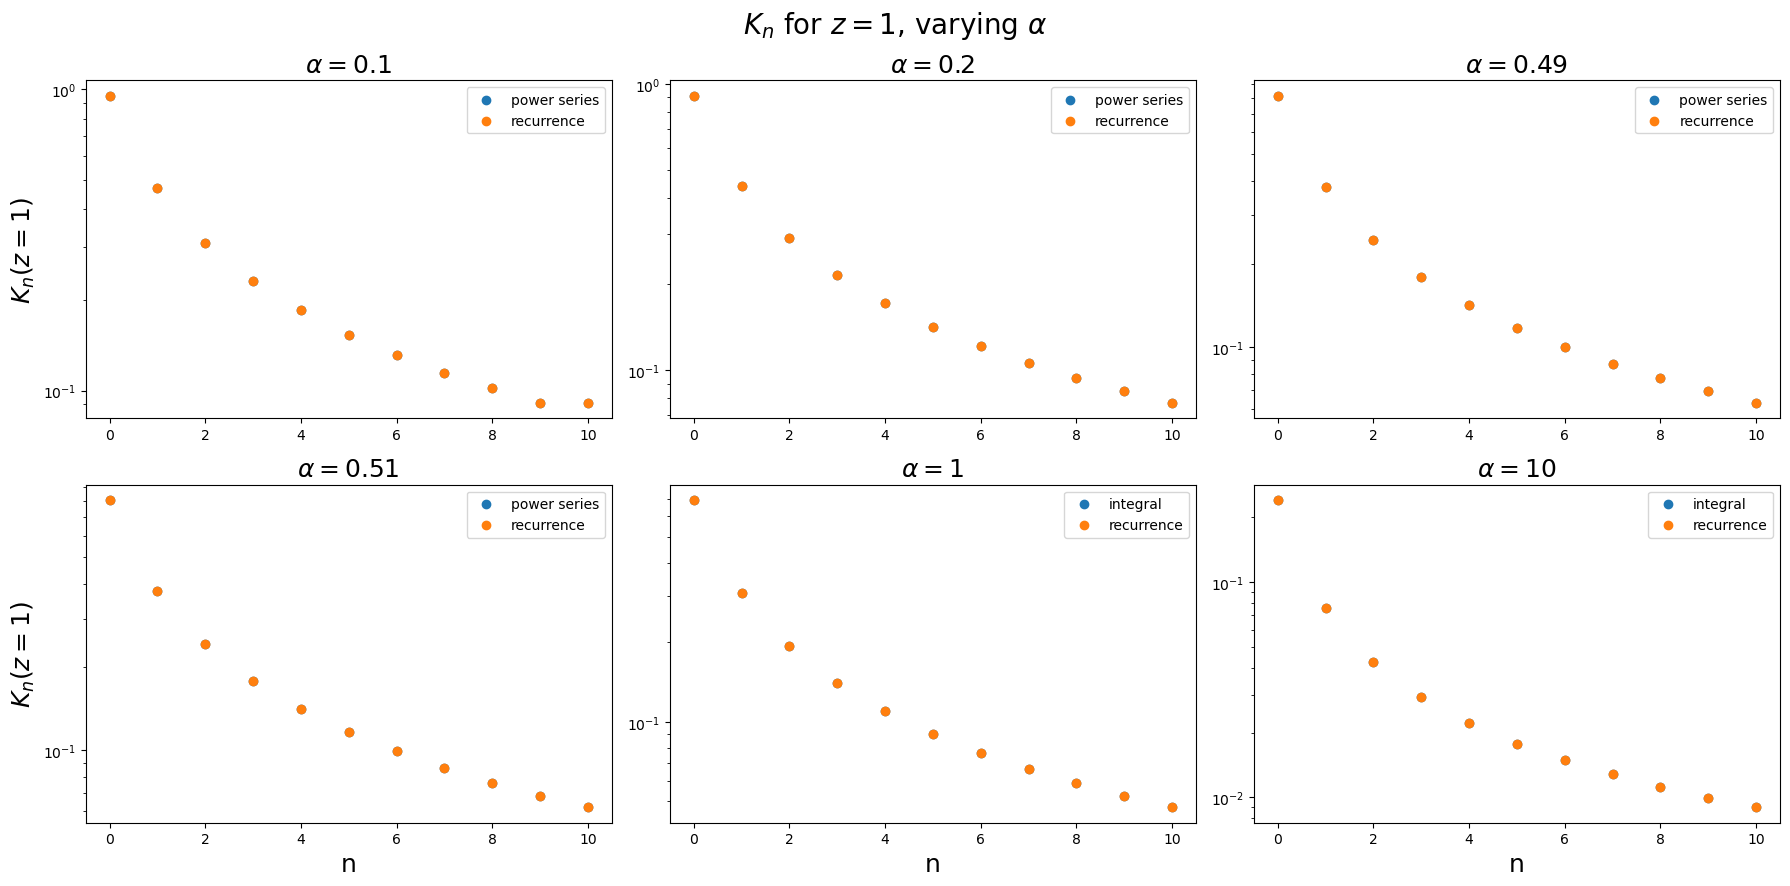

In [212]:
alphas = [0.1, 0.2, 0.49, 0.51, 1, 10]
z = 1
fig, axs = plt.subplots(2, 3, figsize=(18, 9))
x_axis = [i for i in range(0, 11)]

for alpha, ax in zip(alphas, axs.ravel()):
    solver = KnSolver(alpha=alpha, z=[z], n_max=10, epsilon=1e-10)
    if alpha/z < 1:
        ax.scatter(x_axis, solver.solve_analytically_at_z(z), label='power series')
    else:
        ax.scatter(x_axis, solver.solve_Kn_integral(), label='integral')
        
    ax.scatter(x_axis, solver.calculate_Kn_at_z(z), label='recurrence')
    
    ax.set_yscale('log')
    ax.set_title(r'$\alpha=$' + f'{alpha}', fontsize=18)
    ax.legend()

axs[0][0].set_ylabel(r'$K_n(z=1)$', fontsize=18)
axs[1][0].set_ylabel(r'$K_n(z=1)$', fontsize=18)
axs[1][0].set_xlabel(r'n', fontsize=18)
axs[1][1].set_xlabel(r'n', fontsize=18)
axs[1][2].set_xlabel(r'n', fontsize=18)

fig.suptitle(r'$K_n$ for $z=1$, varying $\alpha$', fontsize=20)
plt.tight_layout()

In [184]:
for n in range(10 - 1, -1, -1):
    print(n)
    #print(10-n)
    #print('--------')

9
8
7
6
5
4
3
2
1
0


In [73]:
alphas = [0.001, 0.1, 0.49, 0.5, 1, 10]

for alpha in alphas:
    solver = KnSolver(alpha=alpha, z=[0.1], n_max=10, epsilon=1e-10)
    
    print(f'Alpha is {alpha}')
    print(f'Alpha is {alpha}')
    Kn = solver.calculate_Kn_at_z(0.1)
    Kn_integral = solver.solve_Kn_integral()
    Kn_analytic = solver.solve_analytically()

Alpha is 0.001
Alpha is 0.001
Number of iterations: 7
-0.009950330853166666
1.0000000000000002e-12
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.42641454e+08]
fK9 is 142641454.2038401
fK8 is -1426413.5420384011
fK7 is 14265.246531495122
fK6 is -141.40246531495123
fK5 is 2.842596081720941
fK4 is 1.6382407058494572
fK3 is 1.9836175929415054
fK2 is 2.480163824070585
fK1 is 3.3085316950926273
fK0 is 4.966914683049073
Number of iterations: 7
-0.009950330853166666
1.0000000000000002e-12
Number of iterations: 7
-0.009950330853166666
1.0000000000000002e-12
Number of iterations: 7
-0.009950330853166666
1.0000000000000002e-12
Number of iterations: 7
-0.009950330853166666
1.0000000000000002e-12
Number of iterations: 7
-0.009950330853166666
1.0000000000000002e-12
Number of iterations: 7
-0.009950330853166666
1.0000000000000002e-12
Number of iterations: 7
-0.009950330853166666
1.000000000000

/var/folders/gl/qkjlxgd944l2rvbjy6m3dk900000gr/T/ipykernel_99547/2234296402.py:24: RuntimeWarning: overflow encountered in scalar power
  coefficient = (-self._alpha / z)**k
/var/folders/gl/qkjlxgd944l2rvbjy6m3dk900000gr/T/ipykernel_99547/2234296402.py:25: RuntimeWarning: invalid value encountered in scalar add
  sum += coefficient / k


Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Alpha is 0.5
Alpha is 0.5
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Alpha is 1
Alpha is 1
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 100001
nan
inf
Number of iterations: 10000

In [152]:
solver = KnSolver(alpha=0.04, z=[0.1], n_max=10, epsilon=1e-10)

Kn = solver.solve_analytically_at_z(0.1)
Kn

Number of iterations: 27
Number of iterations: 27
Number of iterations: 27
Number of iterations: 27
Number of iterations: 27
Number of iterations: 27
Number of iterations: 27
Number of iterations: 27
Number of iterations: 27
Number of iterations: 27
Number of iterations: 27


[8.411805915518284,
 3.9704852112042843,
 2.573786971989289,
 1.8988659033601085,
 1.5028352415997341,
 1.242911896000634,
 1.0593869266650562,
 0.9229612547660953,
 0.817596863087887,
 0.7337856200618923,
 0.665535949850751]

In [118]:
solver = KnSolver(alpha=0.04, z=[0.1], n_max=10, epsilon=1e-10)
solver.downwards_recurrence_at_z(0.1)

Number of iterations: 27
-0.3364722366207314
4.5035996273704865e-11
fK9 is 1.1480684567084787e-07
fK8 is 0.9999999540772616
fK7 is 0.7111111294802064
fK6 is 0.9655555482079173
fK5 is 1.0423492092882614
fK4 is 1.2497269829513622
fK3 is 1.500109206819455
fK2 is 1.8999563172722178
fK1 is 2.5733508064244464
fK0 is 3.9706596774302207


array([0.        , 0.99999995, 0.71111113, 0.96555555, 1.04234921,
       1.24972698, 1.50010921, 1.89995632, 2.57335081, 3.97065968,
       8.41173613])

In [119]:
solver.solve_Kn_integral()

array([8.41180592, 3.97048521, 2.57378697, 1.8988659 , 1.50283524,
       1.24291189, 1.05938693, 0.92296125, 0.81759688, 0.73378557,
       0.66553606])

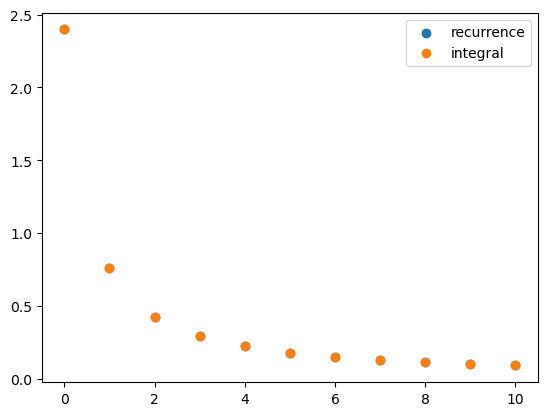

In [83]:
alphas = [1] # 0.001, 0.5,

for alpha in alphas:
    solver = KnSolver(alpha=alpha, z=[0.1], n_max=10, epsilon=1e-10)
    
    Kn = solver.calculate_Kn_at_z(0.1)
    Kn_integral = solver.solve_Kn_integral()
    
fig, ax = plt.subplots()
x_axis = [i for i in range(11)]
ax.scatter(x_axis, Kn, label='recurrence')
ax.scatter(x_axis, Kn_integral, label='integral')
    
ax.legend()

Text(0.5, 1.0, 'Integral Solutions')

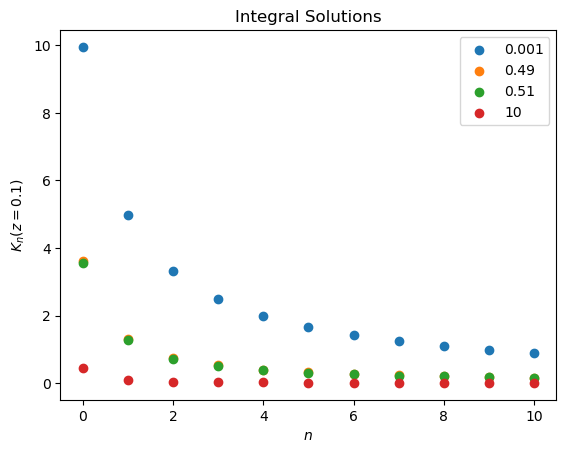

In [91]:
fig, ax = plt.subplots()
x_axis = [i for i in range(11)]

alphas = [0.001, 0.49, 0.51, 10]
for alpha in alphas:
    solver = KnSolver(alpha=alpha, z=[0.1], n_max=10, epsilon=1e-10)
    
    Kn_integral = solver.solve_Kn_integral()
    
    ax.scatter(x_axis, Kn_integral, label=f'{alpha}')
    
ax.legend()
ax.set_ylabel(r'$K_{n}(z=0.1)$')
ax.set_xlabel(r'$n$')
ax.set_title('Integral Solutions')

KN SHAPE: (11,)


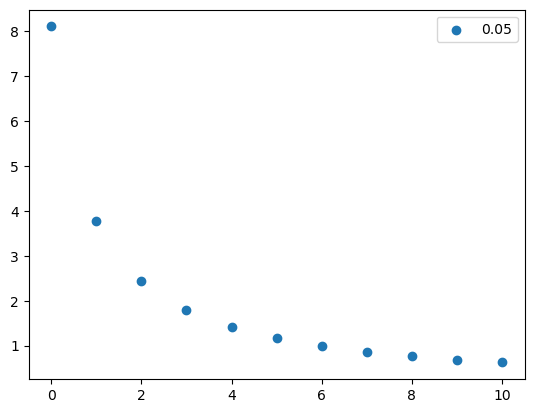

In [105]:
fig, ax = plt.subplots()
x_axis = [i for i in range(11)]

#alphas =  [0.49, 0.51, 10] # 
alphas = [0.05]
for alpha in alphas:
    solver = KnSolver(alpha=alpha, z=[0.1], n_max=10, epsilon=1e-10)
    
    Kn = solver.calculate_Kn_at_z(0.1)
    
    print(f'KN SHAPE: {Kn.shape}')
    ax.scatter(x_axis, Kn, label=f'{alpha}')

ax.legend()

In [26]:
Kn

array([2.39789527, 0.76021047, 0.42397895, 0.29093544, 0.22090646,
       0.17790935, 0.14887573, 0.12796957, 0.11220304, 0.09989081])

In [27]:
Kn_integral

array([[2.39789527],
       [0.76021047],
       [0.42397895],
       [0.29093544],
       [0.22090646],
       [0.17790935],
       [0.14887573],
       [0.12796957],
       [0.11220304],
       [0.09989081]])

In [11]:
Kzero

2.3978952727983707

Number of iterations: 5
-0.0009995003330833332
1.0000000000000002e-12


ValueError: x and y must be the same size

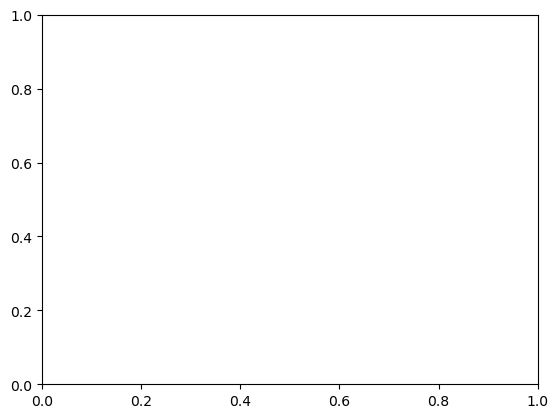

In [31]:
alphas = [0.001, 0.5, 10]

for alpha in alphas:
    solver = KnSolver(alpha=alpha, z=[1], n_max=10, epsilon=1e-10)
    
    solver.analytic_solution_Kn_at_z(10, z=1)
    #Kn = solver.solve_Kn_integral()
    #print(Kn.shape)
    plt.scatter(np.arange(0, 11), Kn.flatten())

In [65]:
1e-200

1e-200

In [14]:
#solver = KnSolver(0.1, np.array([1, 2, 3, 4]), 10, 1e-2)
solver = KnSolver(1e-4, np.array([1, 2, 3, 4]), 10, 1e-2)


In [22]:
hist = test = solver.solve_analytically()

Number of iterations: 2
-0.0001
-0.0001
Number of iterations: 2
-5e-05
-5e-05
Number of iterations: 2
-3.3333333333333335e-05
-3.3333333333333335e-05
Number of iterations: 2
-2.5e-05
-2.5e-05
Number of iterations: 2
-0.0001
-0.0001
Number of iterations: 2
-5e-05
-5e-05
Number of iterations: 2
-3.3333333333333335e-05
-3.3333333333333335e-05
Number of iterations: 2
-2.5e-05
-2.5e-05
Number of iterations: 2
-0.0001
-0.0001
Number of iterations: 2
-5e-05
-5e-05
Number of iterations: 2
-3.3333333333333335e-05
-3.3333333333333335e-05
Number of iterations: 2
-2.5e-05
-2.5e-05
Number of iterations: 2
-0.0001
-0.0001
Number of iterations: 2
-5e-05
-5e-05
Number of iterations: 2
-3.3333333333333335e-05
-3.3333333333333335e-05
Number of iterations: 2
-2.5e-05
-2.5e-05
Number of iterations: 2
-0.0001
-0.0001
Number of iterations: 2
-5e-05
-5e-05
Number of iterations: 2
-3.3333333333333335e-05
-3.3333333333333335e-05
Number of iterations: 2
-2.5e-05
-2.5e-05
Number of iterations: 2
-0.0001
-0.0001
